## Import the packages

In [1]:
import pandas as pd
import re
import numpy as np
import string
import matplotlib.pyplot as plt

## Load the data

In [2]:
df1 = pd.read_csv(r"news_summary.csv",encoding='iso-8859-1',usecols=['headlines','text'])
df2 = pd.read_csv(r"news_summary_more.csv",encoding='iso-8859-1')

In [3]:
df1.head()

,headlines,text
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...


In [4]:
df1.shape

(4514, 2)

In [5]:
df2.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [6]:
df2.shape

(98401, 2)

## Data Preprocessing

The aim of the preprocessing step is to reduce the
dimensionality of the representation space, and it normally includes: (i) stop-word
elimination – common words with no semantics and which do not aggregate relevant
information to the task (e.g., “the”, “a”) are eliminated;; (ii) case folding: consists of
converting all the characters to the same kind of letter case - either upper case or
lower case; (iii) stemming: syntactically-similar words, such as plurals, verbal
variations, etc. are considered similar; the purpose of this procedure is to obtain the
stem or radix of each word, which emphasize its semantics.

In [7]:
#concatenate two dataframes to get total data
df = pd.concat([df1,df2],axis=0,ignore_index=True)
df.head()

,headlines,text
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...


In [8]:
df.shape

(102915, 2)

In [9]:
# drop duplicates and null values
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(100266, 2)

In [11]:
print(f'Dataset size : {df.shape[0]}')

Dataset size : 100266


In [12]:
def cleantext(text):
    text = str(text)
    text=text.split()
    words=[]
    for t in text:
        if t.isalpha():
            words.append(t)
    text=" ".join(words)
    text=text.lower()
    text=re.sub(r"what's","what is ",text)
    text=re.sub(r"it's","it is ",text)
    text=re.sub(r"\'ve"," have ",text)
    text=re.sub(r"i'm","i am ",text)
    text=re.sub(r"\'re"," are ",text)
    text=re.sub(r"n't"," not ",text)
    text=re.sub(r"\'d"," would ",text)
    text=re.sub(r"\'s","s",text)
    text=re.sub(r"\'ll"," will ",text)
    text=re.sub(r"can't"," cannot ",text)
    text=re.sub(r" e g "," eg ",text)
    text=re.sub(r"e-mail","email",text)
    text=re.sub(r"9\\/11"," 911 ",text)
    text=re.sub(r" u.s"," american ",text)
    text=re.sub(r" u.n"," united nations ",text)
    text=re.sub(r"\n"," ",text)
    text=re.sub(r":"," ",text)
    text=re.sub(r"-"," ",text)
    text=re.sub(r"\_"," ",text)
    text=re.sub(r"\d+"," ",text)
    text=re.sub(r"[$#@%&*!~?%{}()]"," ",text)

    return text

In [13]:
for col in df.columns:
    df[col] = df[col].apply(lambda x: cleantext(x))

In [14]:
df.head()

,headlines,text
0,daman diu revokes mandatory rakshabandhan in o...,the administration of union territory daman an...
1,malaika slams user who trolled her for rich,malaika arora slammed an instagram user who tr...
2,now corrected to in form,the indira gandhi institute of medical science...
3,aaj aapne pakad let man dujana before being ki...,kashmir commander abu who was killed by securi...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...


In [15]:
data = pd.DataFrame()
data['text'] = df['text']
data['summary'] = df['headlines']

Remember to add the START and END special tokens at the beginning and end of the summary. Here, I have chosen sostok and eostok as START and END tokens. The beginning-of-sentence token serves as an instruction to the decoder to start decoding (it needs a very first state to predict what the next first token is). The end-of-sentence token is an instruction for the decoding algorithm to stop generating more tokens

## Understanding distribution of sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

In [16]:
text_count = 0
for text in data['text']:
    if len(text.split())<60:
        text_count += 1
print(text_count/len(data['text']))

0.9999900265294317


In [17]:
summary_count = 0
for summary in data['summary']:
    if len(summary.split())<15:
        summary_count+=1
print(summary_count/len(data['summary']))

0.9999601061177269


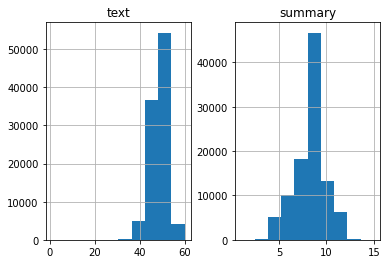

In [18]:
text_word_count = []
summary_word_count = []

# get number of words in text and summary

for i in data['text']:
    text_word_count.append(len(i.split()))
    
for i in data['summary']:
    summary_word_count.append(len(str(i).split()))
    
length = pd.DataFrame()
length['text'] = pd.Series(text_word_count)
length['summary'] = pd.Series(summary_word_count)

length.hist(bins=10)
plt.show()

In [19]:
max_text_len=60
max_summary_len=17

In [20]:

text =np.array(data['text'])
summary=np.array(data['summary'])

short_text=[]
short_summary=[]

for i in range(len(text)):
    if(len(str(summary[i]).split())<=max_summary_len and len(text[i].split())<=max_text_len):
        short_text.append(text[i])
        short_summary.append(summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})


In [21]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

## Split the dataset

In [22]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

## Tokenize: text_to_word_sequence

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [27]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 56.57998805546139
Total Coverage of rare words: 1.1902033035582427


## Padding: pad_sequences

In [28]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [29]:
x_voc

26901

In [30]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [31]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 55.537201701050854
Total Coverage of rare words: 2.6054205341817265


In [32]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [33]:
y_voc

12652

In [34]:
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Embedding,LSTM,Input,TimeDistributed,Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
K.clear_session()

K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 100)      2690100     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 300), (N 481200      embedding[0][0]                  
_____________________________________________________________________________________________

In [39]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [40]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=2,callbacks=[es],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 90239 samples, validate on 10027 samples
Epoch 1/2
 1024/90239 [..............................] - ETA: 4:05 - loss: 3.3968 - acc: 0.5378

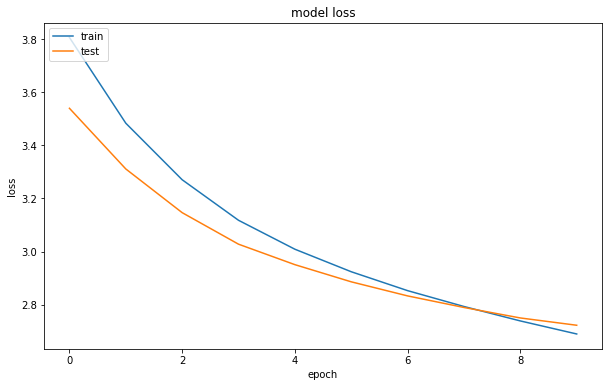

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [38]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [39]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [40]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [41]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: the wwe has confirmed the will return to the ring for the first time since wrestlemania in which he lost and left his iconic coat and hat in the sparking retirement he will return on flagship raw anniversary on january who retired in will also attend the 
Original summary: the to make wwe return on anniversary 
Predicted summary:  to be auctioned for first time


Review: as many as three people were killed in riots after dera sacha sauda chief gurmeet ram rahim was convicted of rape by a cbi court on railway station and a petrol pump were set on fire amid clashes between security forces and the reports said over cars were set on 
Original summary: dead in riots after dera chief ram rahim convicted of rape 
Predicted summary:  people who killed in bihar shelter shelter home


Review: bengaluru police has claimed they have solved cases after arresting a in the named had snatched gold chains of people in and around and had warrants pending against him from different police said th